
# MMLU Score vs. Parameter Count

This notebook reads model performance data and builds an SVG chart showing MMLU score
versus parameter count on a logarithmic scale.


Import required libraries.

In [1]:

import csv
import math

import numpy as np


Load model performance data from `data.csv`.

In [2]:

rows = []
with open('data.csv', 'r') as file_in:
    for name, mmlu, params, citation in csv.reader(file_in):
        if name == 'Model':
            continue
        rows.append((name, float(mmlu.rstrip('%')), float(params)))


Determine the most efficient models in three parameter ranges to form the frontier.

In [3]:
frontier_rows = []

def add_best(group):
    if not group:
        return
    best = max(group, key=lambda row: row[1])
    if best in frontier_rows:
        return
    frontier_rows.append(best)

groups = []
groups.append([r for r in rows if r[2] <= 1])
groups.append([r for r in rows if 1 < r[2] < 8])
groups.append([r for r in rows if 8 <= r[2] < 100])
groups.append([r for r in rows if r[2] >= 100])

for group in groups:
    add_best(group)

frontier_names = {name for (name, _, _) in frontier_rows}


Set chart dimensions and coordinate transforms.

In [4]:
width, height = 800, 500
margin = 60

mmlu_vals = [m for _, m, _ in rows]
param_vals = [p for _, _, p in rows]
min_mmlu, max_mmlu = 0, 100
raw_min_params = min(param_vals)
min_params = max(raw_min_params * 0.8, 0.1)
max_params = max(param_vals)
if min_params <= 0:
    raise ValueError('Parameter counts must be positive for log scale.')
log_min_params = math.log10(min_params)
log_max_params = math.log10(max_params)


def point_x(mmlu):
    return margin + (mmlu - min_mmlu) / (max_mmlu - min_mmlu) * (width - 2 * margin)


def point_y(params):
    ratio = (math.log10(params) - log_min_params) / (log_max_params - log_min_params)
    return margin + (1 - ratio) * (height - 2 * margin)


Prepare label positions and connectors for the chart.

In [5]:

points = [(n, point_x(m), point_y(p)) for (n, m, p) in rows]

left_points = [pt for pt in points if pt[0] not in frontier_names]
right_points = [pt for pt in points if pt[0] in frontier_names]

left_sorted = sorted(left_points, key=lambda pt: pt[2])
right_sorted = sorted(right_points, key=lambda pt: pt[2])

n_left = len(left_sorted)
base_font_size = 10
if n_left > 0:
    max_label_height = (height - 2 * margin) / n_left
    font_size_left = min(base_font_size, max(6, max_label_height * 0.8))
else:
    font_size_left = base_font_size
font_size_right = 10
char_width = 0.6

min_y_left = margin + font_size_left / 2
max_y_left = height - margin - font_size_left / 2
spacing_left = (max_y_left - min_y_left) / (n_left - 1) if n_left > 1 else 0

left_labels = []
for i, (name, px, py) in enumerate(left_sorted):
    y_label = min_y_left + i * spacing_left
    width_label = len(name) * font_size_left * char_width
    height_label = font_size_left
    x_label = margin + 5
    left_labels.append(
        {
            'name': name,
            'point': (px, py),
            'label_pos': (x_label, y_label),
            'width': width_label,
            'height': height_label,
            'font_size': font_size_left,
        }
    )

right_labels = []
for name, px, py in right_sorted:
    font_size = font_size_right
    available = width - margin - (px + 5)
    max_width = len(name) * font_size * char_width
    if max_width > available:
        font_size = max(6, available / (len(name) * char_width))
        max_width = len(name) * font_size * char_width
    x_label = px + 5
    y_label = py
    right_labels.append(
        {
            'name': name,
            'point': (px, py),
            'label_pos': (x_label, y_label),
            'width': max_width,
            'height': font_size,
            'font_size': font_size,
        }
    )

boxes = {}
for lbl in left_labels:
    name = lbl['name']
    lx, ly = lbl['label_pos']
    w, h = lbl['width'], lbl['height']
    boxes[name] = (lx, ly - h / 2, lx + w, ly + h / 2)

for lbl in right_labels:
    name = lbl['name']
    lx, ly = lbl['label_pos']
    w, h = lbl['width'], lbl['height']
    boxes[name] = (lx, ly - h / 2, lx + w, ly + h / 2)


def segment_collision(seg_from, seg_to, exclude_name):
    x1, y1 = seg_from
    x2, y2 = seg_to
    xs = np.linspace(x1, x2, 30)
    ys = np.linspace(y1, y2, 30)
    for xi, yi in zip(xs, ys):
        for name, (xmin, ymin, xmax, ymax) in boxes.items():
            if name == exclude_name:
                continue
            if xmin < xi < xmax and ymin < yi < ymax:
                return True
    return False

left_connectors = []
for lbl in left_labels:
    name = lbl['name']
    px, py = lbl['point']
    lx, ly = lbl['label_pos']
    w, h = lbl['width'], lbl['height']
    top_anchor = (lx + w, ly - h / 2)
    bottom_anchor = (lx + w, ly + h / 2)
    top_coll = segment_collision((px, py), top_anchor, name)
    bottom_coll = segment_collision((px, py), bottom_anchor, name)
    if not top_coll:
        anchor = top_anchor
    elif not bottom_coll:
        anchor = bottom_anchor
    else:
        dist_top = abs(py - top_anchor[1])
        dist_bottom = abs(py - bottom_anchor[1])
        anchor = top_anchor if dist_top < dist_bottom else bottom_anchor
    left_connectors.append((name, (px, py), anchor))

right_connectors = []
for lbl in right_labels:
    name = lbl['name']
    px, py = lbl['point']
    lx, _ = lbl['label_pos']
    anchor = (lx, py)
    right_connectors.append((name, (px, py), anchor))


Assemble the SVG elements and write them to `graph.svg`.

In [6]:

svg = []
svg.append(
    f'<svg width="{width}" height="{height}" '
    f'xmlns="http://www.w3.org/2000/svg" font-family="sans-serif">'
)
svg.append(f'<rect x="0" y="0" width="{width}" height="{height}" fill="white"/>')

x_axis_y = point_y(min_params)
svg.append(
    f'<line x1="{margin}" y1="{x_axis_y}" x2="{width - margin}" '
    f'y2="{x_axis_y}" stroke="black"/>'
)
y_axis_x = margin
svg.append(
    f'<line x1="{y_axis_x}" y1="{margin}" x2="{y_axis_x}" '
    f'y2="{height - margin}" stroke="black"/>'
)

for tick in range(int(min_mmlu), int(max_mmlu) + 1, 5):
    tx = point_x(tick)
    svg.append(f'<line x1="{tx}" y1="{x_axis_y}" x2="{tx}" y2="{x_axis_y + 5}" stroke="black"/>')
    svg.append(
        f'<text x="{tx}" y="{x_axis_y + 20}" font-size="8" text-anchor="middle">{tick}</text>'
    )

for exponent in range(int(math.floor(log_min_params)), int(math.ceil(log_max_params)) + 1):
    val = 10 ** exponent
    if val < min_params:
        continue
    if val > max_params:
        continue
    ty = point_y(val)
    svg.append(
        f'<line x1="{y_axis_x}" y1="{ty}" x2="{y_axis_x - 5}" y2="{ty}" stroke="black"/>'
    )
    label_str = f'10^{exponent}'
    svg.append(
        f'<text x="{y_axis_x - 10}" y="{ty + 3}" font-size="8" text-anchor="end">{label_str}</text>'
    )

for name, px, py in points:
    color = 'red' if name in frontier_names else 'blue'
    svg.append(f'<circle cx="{px}" cy="{py}" r="3" fill="{color}"/>')

frontier_list = []
for n, px, py in right_points:
    for nm, mmlu, params in rows:
        if nm == n:
            frontier_list.append((n, px, py, params))
            break

if len(frontier_list) > 1:
    frontier_list.sort(key=lambda t: t[3])
    poly_parts = [f"{px},{py}" for (_, px, py, _) in frontier_list]
    poly_points = " ".join(poly_parts)
    svg.append(
        f'<polyline fill="none" stroke="red" stroke-width="1" points="{poly_points}"/>'
    )
    max_label_right = max(l['label_pos'][0] + l['width'] for l in right_labels)
    label_x = max_label_right + 10
    avg_py = sum(py for (_, _, py, _) in frontier_list) / len(frontier_list)
    svg.append(
        f'<text x="{label_x}" y="{avg_py}" font-size="10" font-weight="bold" '
        f'fill="red" text-anchor="start">Frontier</text>'
    )

for name, (x1, y1), (x2, y2) in left_connectors:
    svg.append(
        f'<line x1="{x1}" y1="{y1}" x2="{x2}" y2="{y2}" stroke="gray" stroke-width="0.5"/>'
    )
    lbl = next(l for l in left_labels if l['name'] == name)
    lx, ly = lbl['label_pos']
    fs = lbl['font_size']
    text_y = ly + fs * 0.35
    svg.append(
        f'<text x="{lx}" y="{text_y}" font-size="{fs}" text-anchor="start">{name}</text>'
    )

for name, (x1, y1), (x2, y2) in right_connectors:
    svg.append(
        f'<line x1="{x1}" y1="{y1}" x2="{x2}" y2="{y2}" stroke="gray" stroke-width="0.5"/>'
    )
    lbl = next(l for l in right_labels if l['name'] == name)
    lx, ly = lbl['label_pos']
    fs = lbl['font_size']
    text_y = ly + fs * 0.35
    svg.append(
        f'<text x="{lx}" y="{text_y}" font-size="{fs}" text-anchor="start">{name}</text>'
    )

svg.append(
    f'<text x="{width / 2}" y="{margin / 2}" font-size="14" text-anchor="middle" '
    f'font-weight="bold">MMLU Score vs. Parameter Count</text>'
)
svg.append(
    f'<text x="{width / 2}" y="{height - 10}" font-size="10" text-anchor="middle">'
    f'MMLU Score (Average Undergrad Scores 90%)</text>'
)
svg.append(
    f'<text x="15" y="{height / 2}" font-size="10" text-anchor="middle" '
    f'transform="rotate(-90,15,{height / 2})">Parameters (log scale)</text>'
)

svg.append('</svg>')

with open('graph.svg', 'w') as file_out:
    for line in svg:
        file_out.write(line + '\n')

print('SVG chart saved to graph.svg')


SVG chart saved to graph.svg


Display the generated SVG chart.

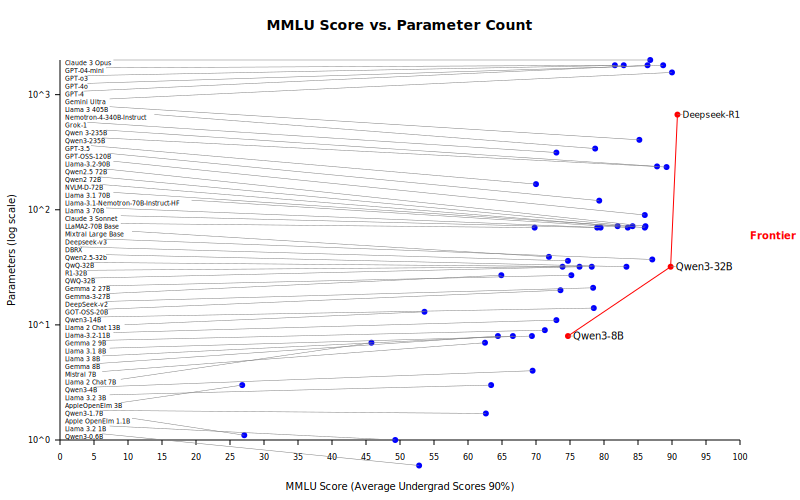

In [7]:

from IPython.display import SVG, display

display(SVG('graph.svg'))


The chart highlights models on the efficiency frontier in red while showing others in blue. Labels and connectors identify each model, and the SVG is saved as `graph.svg`.